### Notebook to Research diabetes onset 


#### Matched Controls Diabetes Onset Curve Construction Details

   1. <div style="background:Aliceblue"> <strong>Get all the canary patients who have their CC_DIABETES flag equals 0
    on their registration date.</strong>
   </div>
   
       - Pick a matching algorithm
       
   2. <div style="background:Aliceblue"><strong> Create the macthed population</strong> </div>
   
       - For each canary patient let their registration month be $i$
       - Find N(for example 50)  control patients to match this canary patient from the pmpm 
       patients on month i who have CC_DIABETES = 0 on month i. For example a matching specification could require the N patients should have the same age 
       and then be the nearest neighbors according to other features(log costs, cc codes etc).
       - Set the index date for these pmpm controls patients to be month $i$.
       - This forms a matched set of roughly 50 times the number of canary patients and each control has an index date.
   
   3. <div style="background:Aliceblue"><strong> Compute Onset of Diabetes for month $i$<strong></div> 
   
       - Get all the matched controls with index date prior to month $i$.
       - For Month i we define the total number of Diabetes Onsets(DO) as the number of subjects from <strong> 2 </strong> that had
        the flag $CC_{DIABETES} = 1$ at Month $(i)$ and $CC_{DIABETES} = 0$ at Month $(i-1)$ (Note these patients must be in pmpm on both months).
       - S is the total number of matched controls included in the pmpm both in month $i$ and month $i-1$
       - For Month i we define the diabetes onset rate(DOR) as: $DOR =  1000DO/S$

    <div style="background:Lightskyblue"> <strong>Suggestion:</strong> Remove from  $S$ the subjects that  have the flag $CC_{DIABETES} = 1$ at month $i-1$
    </div>

   

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext Cython


In [2]:
%reload_ext Cython

In [3]:
import sys
sys.path.append('..')
import warnings
def warn(message = None, category=None, stacklevel=1, source=None):
    pass

warnings.warn = warn

In [4]:
import scipy.stats as sts
import pandas as pd
import numpy as np
import time
import datetime as dt
from pathlib import Path
import time
#custom
from data_functions import make_date_to_MYR
from diabetes_onset import( process_canary,
get_tc, in_canary, diabet_onset, not_first_month_diabetes, 
                           match_data_per_month, 
                           filter_first_month_diabetes,
                           matched_population, 
                           propensity_func,
                           nearest_neighbor_func, 
                           random_matching_func, agglomerative )

from tqdm import tqdm
from sklearn.neighbors import NearestNeighbors
import pyarrow.parquet as pq
import seaborn as sns
import matplotlib.pyplot as plt
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
np.random.seed(seed = 0)

### Load Pmpm, Canary data

In [5]:
%%time
canary_p = '../../../data/CANARY/CANARY202104'
pmpm_p = '../../../temp/PMPM.p'
preg_p = '../../../data/pregnancies'

preg = pq.read_table(preg_p).to_pandas()
canary = pq.read_table(canary_p).to_pandas()
pmpm = pd.read_pickle(pmpm_p)

#drop pmpm duplicates
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)
canary.drop_duplicates(subset = ['PERS_ID'], inplace = True)

CPU times: user 5.96 s, sys: 6.76 s, total: 12.7 s
Wall time: 12.6 s


In [6]:
pmpm.MEDICAID_LOB.unique()

array(['Medicare', 'Commercial', 'Other', 'ASO', 'Medicaid-HARP',
       'Medicaid-TANF', 'Medicaid-SSI', 'Medicaid-CHP', 'Medicaid-Other'],
      dtype=object)

### Include Line of Bussiness Feature 1 Not medicaid 0 medicaid

In [7]:
medicaid_mask = pmpm.MEDICAID_LOB.str.contains(r'.*Medicaid-.*')
pmpm['LOB'] = 1
pmpm.loc[medicaid_mask, 'LOB'] = 0

In [8]:
preg = preg.rename(mapper = {'person_id':'PERS_ID'}, axis = 1)
preg = pd.melt(preg, id_vars = ['PERS_ID'], value_vars=['stay_start_date', 'stay_end_date'], value_name='MYR')
preg.MYR = preg.MYR.apply(lambda x: x.year*100+x.month)
preg.drop(labels = 'variable', axis = 1, inplace = True)
preg['PREGNANCY'] = 1

In [9]:
%%time
pmpm = pmpm.merge(preg, how = 'left', on = ['PERS_ID', 'MYR'])
pmpm.PREGNANCY = pmpm.PREGNANCY.fillna(value = 0)
pmpm.drop_duplicates(subset = ['PERS_ID', 'MYR'], inplace = True)

CPU times: user 11.9 s, sys: 7.47 s, total: 19.3 s
Wall time: 19.3 s


In [10]:
from utils import ip_er2

In [11]:
%%time
pmpm = pmpm.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)
pmpm['IP_BIN'] = ((pmpm.ALLOW_IP>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ER_BIN'] = ((pmpm.ALLOW_ER>0) & (pmpm.PREGNANCY == 0)).astype(int)
pmpm['ACUTE'] =  ((pmpm.IP_BIN>0) | (pmpm.ER_BIN > 0 )).astype(int)

CPU times: user 7.22 s, sys: 2.79 s, total: 10 s
Wall time: 10 s


In [12]:
%%time
pmpm[['IP_C', 'ER_C', 'ACUTE_C']] = pmpm.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN', 'ACUTE']].cumsum().reset_index(drop = True)
pmpm[['IP_BIN6', 'ER_BIN6', 'ACUTE6']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C', 'ACUTE_C']].diff(6).fillna(pmpm[['IP_C', 'ER_C','ACUTE_C']]).reset_index(drop = True)
pmpm[['IP_BIN2', 'ER_BIN2','ACUTE2']] = pmpm.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C','ACUTE_C']].diff(2).fillna(pmpm[['IP_C', 'ER_C','ACUTE_C']]).reset_index(drop = True)

CPU times: user 3min 38s, sys: 9.66 s, total: 3min 48s
Wall time: 3min 42s


#undersample
test = test.sample(random_state = 0, frac = 0.01).reset_index(drop = True)
test = test.sort_values(by = ['PERS_ID', 'MYR']).reset_index(drop = True)

%%time

test[['IP_C', 'ER_C']] = test.groupby('PERS_ID', sort = False)[['IP_BIN', 'ER_BIN']].cumsum().reset_index(drop = True)
test[['IP_BIN2', 'ER_BIN2']] = test.groupby('PERS_ID', sort = False)[['IP_C', 'ER_C']].diff(6).fillna(test[['IP_C', 'ER_C']]).reset_index(drop = True)

In [13]:
pmpm.head()

PERS_ID     MYR MBR_GNDR  AGE_AT_MIDMONTH  ALLOW_AMT MEDICAID_LOB  ALLOW_ER  ALLOW_IP  CC_ADHD  CC_ALZHEIMER  CC_ALZHEIMER_PLUS  CC_AMI  CC_ANEMIA  CC_ANXIETY_DISORDER  CC_ARTHRITIS  CC_ASTHMA  CC_ATRIAL_FIB  CC_AUTISM  CC_BIPOLAR  CC_BPH  CC_BREAST_CANCER  CC_CATARACT  CC_CEREBRAL_PALSY  CC_CHRONIC_KIDNEY  CC_COLORECTAL_CANCER  CC_COPD  CC_CYSTIC_FIBROSIS  CC_DEPRESSION  CC_DEPRESSIVE_DISORDERS  CC_DEVELOP_DELAYS  CC_DIABETES  CC_DISAB_DX_CNT  CC_DX_CNT  CC_ENDOMETRIAL_CANCER  CC_EPILEPSY  CC_FIBROMYALGIA  CC_GLAUCOMA  CC_HEARING_IMPAIR  CC_HEART_FAILURE  CC_HEPATITIS_A  CC_HEPATITIS_B_ACUTE  CC_HEPATITIS_B_CHRONIC  CC_HEPATITIS_C_ACUTE  CC_HEPATITIS_C_CHRONIC  CC_HEPATITIS_C_UNSPECIFIED  CC_HEPATITIS_D  CC_HEPATITIS_E  CC_HEPATITIS_GEN  CC_HIP_FRACTURE  CC_HYPERLIPIDEMIA  CC_HYPERTENSION  CC_HYPOTHYROID  CC_INT_DISAB  CC_ISCHEMIC  CC_LEARN_DISAB  CC_LEUKEMIAS  CC_LIVER  CC_LUNG_CANCER  CC_MIGRAINE  CC_MOBILITY_IMPAIR  CC_MULTIPLE_SCLEROSIS  CC_MUSCULAR_DYSTROPHY  CC_OBESITY  \
0      -3  201908        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
1      -3  201909        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
2      -3  201910        M              119          0   Commercial       0.0       0.0      0.0           0.0                0.0     0.0        0.0                  0.0           0.0        0.0            0.0        0.0         0.0     0.0               0.0          0.0                0.0                0.0                   0.0      0.0                 0.0            0.0                      0.0                0.0          0.0                0          0                    0.0          0.0              0.0          0.0                0.0               0.0             0.0                   0.0                     0.0                   0.0                     0.0                         0.0             0.0             0.0               0.0              0.0                0.0              0.0             0.0           0.0          0.0             0.0           0.0       0.0             0.0          0.0                 0.0                    0.0                    0.0         0.0   
3      -3  201911 

### Process Canary data 
1. Drop register dates beyond pmpm max date
2. Transform register date to MYR
3. Keep only ids and MYR

### Get Controls and Treated
> ***a)Controls are all the patients that did not enrolled in canary program at any point  
b)Treated are the patients that enrolled at some point in the Canary Plan***

In [14]:
%%time
canary2 = process_canary(canary, pmpm.MYR.max())
treated, controls = get_tc(pmpm.copy(), canary2)

CPU times: user 10 s, sys: 5.9 s, total: 15.9 s
Wall time: 15.9 s


### filter by principal reason

In [15]:
controls.PERS_ID.unique().shape, treated.PERS_ID.unique().shape

Keep Canary Patients from their date of registration and onwards who did not have **CC_DIABETES** flag on, on their date of registration.

In [16]:
%%time
treated2 = in_canary(treated.copy(), canary2)
#treated2 = filter_first_month_diabetes(treated2.copy())
treated2.drop(columns = ['IN_CANARY'], inplace = True)

CPU times: user 5.25 s, sys: 46.3 ms, total: 5.29 s
Wall time: 5.29 s


In [17]:
treated2.PERS_ID.unique().shape

In [18]:
#cols = list(col for col in treated2.columns if col not in ['PERS_ID', 'MYR'])
#columns_to_match = cols
columns_to_match = ['AGE_AT_MIDMONTH', 'ALLOW_AMT', 'MBR_GNDR','CC_TOBACCO', 'CC_PRESSURE', 'CC_OBESITY', 'LOB',
                   'CC_HYPERTENSION', 'CC_HYPOTHYROID', 'CC_DX_CNT', 'IP_BIN2', 'ER_BIN2', 'ACUTE', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']

In [ ]:
%%time
"""
#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
#hier_cols = ['IP_BIN2', 'ER_BIN2', 'ACUTE2', 'ACUTE6', 'IP_BIN6', 'ER_BIN6']
hier_cols = ['CC_DX_CNT']
hier_range = [1]
exact_match_dict = {'ACUTE':None, 'ACUTE6':None, 'ACUTE2':None, 'LOB':None}
nnr_func_args = {'match_on':columns_to_match, 'hier_cols':hier_cols,
                        'hier_range':hier_range, 'neighbors_per_treated': 5,
                 'onset': "CC_DIABETES", "onset_val" : 0, 'exact_match': True, 'exact_match_dict': exact_match_dict}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           nearest_neighbor_func, 
                                           nnr_func_args)
"""

#columns_to_match = columns_to_match + ['IP_BIN2', 'ER_BIN2']
propensity_func_args = {'match_on':columns_to_match, 'neighbors_per_treated': 5, 'onset': "CC_DIABETES", "onset_val" : 0}
matched0, matched_data0 = matched_population(treated2.copy(), 
                                           controls.copy(),
                                           propensity_func, 
                                           propensity_func_args)



Mathcing Function: propensity_func
Propensity Score Matching...fitting model
Fitted: GradientBoostingClassifier
Creating Matched Set...


0it [00:00, ?it/s]

iter: 0


200it [11:07,  3.34s/it]

iter: 200


400it [22:37,  3.40s/it]

iter: 400


600it [33:57,  3.38s/it]

iter: 600


800it [45:17,  3.39s/it]

iter: 800


1000it [56:40,  3.50s/it]

iter: 1000


1020it [57:48,  3.41s/it]

####  In addition to the previously created matched groups create a random group

In [45]:
Path('./tempPropSelection').mkdir(exist_ok = True)
p = './tempPropSelection/'
matched_data0.to_pickle(p+'match0.p')
treated2.to_pickle(p+'treated0.p')

In [43]:
random_matching_func_args = {'neighbors_per_treated': 5}
random_controls = matched_population(treated2.copy(), 
                                       controls.copy(),
                                       random_matching_func, 
                                       random_matching_func_args)

Mathcing Function: random_matching_func


KeyboardInterrupt: 

In [46]:
random_controls.to_pickle(p+'random.p')

#### Calculate the Diabetes onset for each of the created groups
1. Group 0: Group of treated patients cluster 0
2. Group 1: Group of treated patients Cluster 1
3. Group 2: Group of matched control patients to Group 0
4. Group 3: Group of matched control patients to Group 1
5. Group 4: Random Group

In [47]:
from utils import statistics_first_month

In [48]:
pmpm2 = pmpm
try:
    pmpm2.MBR_GNDR.replace(to_replace = {'F':0, 'M':1}, inplace = True)
except:
    pass

In [49]:
%%time
tr_desc0, Ntr, treated_first_month = statistics_first_month(treated2, columns_to_match, return_array = True)
tr_desc0 = tr_desc0.T



con_desc0, Ncon, controls_first_month = statistics_first_month(matched_data0, columns_to_match, return_array = True)
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0 = con_desc0.T

pmpm_desc, Npmpm = statistics_first_month(pmpm2, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_desc = pmpm_desc.T

random_desc, Nra = statistics_first_month(random_controls, columns_to_match)
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_desc = random_desc.T

CPU times: user 2min 24s, sys: 4.73 s, total: 2min 29s
Wall time: 2min 29s


In [50]:
import scipy.stats as sts

In [51]:
args = {'mean1':tr_desc0['mean'], 'std1':tr_desc0['std'], 'mean2':con_desc0['mean'], 'std2':con_desc0['std'], 'nobs1': np.full(len(tr_desc0), Ntr) , 'nobs2': np.full(len(tr_desc0), Ncon)}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [52]:
alli = pd.concat((tr_desc0['mean'], con_desc0['mean'], stats, pmpm_desc['mean'], random_desc['mean']), axis = 1, keys = ['Treated', 'Matched Controls', 'T-Test', 'Genaral Population', 'Random'] )

## Statistics on matching date

In [53]:
alli

Treated Matched Controls     T-Test               Genaral Population      Random
                       mean             mean     t-stat          pval               mean        mean
AGE_AT_MIDMONTH   50.202388        50.401758  -0.430260  6.670166e-01          44.643167   47.578065
ALLOW_AMT        676.302326       571.601439   1.437630  1.505735e-01        1086.869268  680.204761
MBR_GNDR           0.205531         0.231118  -2.214697  2.680553e-02           0.440779    0.429230
CC_TOBACCO         0.062225         0.090982  -3.719654  2.006964e-04           0.076138    0.096365
CC_PRESSURE        0.001257         0.005062  -2.083968  3.719095e-02           0.007643    0.006527
CC_OBESITY         0.456945         0.322366  10.309841  8.706247e-25           0.113117    0.228052
LOB                0.952231         0.904223   6.171898  7.035788e-10           0.759449    0.784873
CC_HYPERTENSION    0.324324         0.343946  -1.500235  1.335883e-01           0.216240    0.261326
CC_HYPOTHYROID     0.094280         0.092713   0.195461  8.450366e-01           0.048990    0.066675
CC_DX_CNT          2.703331         2.706407  -0.045813  9.634601e-01           1.882424    2.388021
IP_BIN2            0.010057         0.011056  -0.332561  7.394736e-01           0.020831    0.014589
ER_BIN2            0.029541         0.022779   1.572918  1.157727e-01           0.046643    0.042616
ACUTE              0.014456         0.014653  -0.059366  9.526618e-01           0.062807    0.026875
ACUTE2             0.037712         0.032370   1.030592  3.027596e-01           0.062807    0.053878
ACUTE6             0.110622         0.098841   1.197794  2.310284e-01           0.062807    0.160481
IP_BIN6            0.027027         0.028507  -0.292429  7.699656e-01           0.020831    0.044791
ER_BIN6            0.087995         0.074064   1.658480  9.725505e-02           0.046643    0.124904

In [54]:
tr_desc0A = treated2[columns_to_match].describe().loc[['mean', 'std']]
#tr_desc.index = pd.MultiIndex.from_product([['Treated'], tr_desc.index])
tr_desc0A = tr_desc0A.T


con_desc0A = matched_data0[columns_to_match].describe().loc[['mean', 'std']]
#con_desc.index = pd.MultiIndex.from_product([['Matched'], con_desc.index])
con_desc0A = con_desc0A.T


pmpm_descA = pmpm2[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
pmpm_descA = pmpm_descA.T

random_descA = random_controls[columns_to_match].describe().loc[['mean','std']]
#pmpm_desc.index = pd.MultiIndex.from_product([['PMPM'], pmpm_desc.index])
random_descA = random_descA.T



#### Univariate Means of the Groups under Study of interesting features (Statistics for whole populations)
>The "Sick groups" have:  
a) Older age  
b) More Expenditures  
c) Smoke More  
d) Have More People with Hypertension


In [55]:
args = {'mean1':tr_desc0A['mean'], 'std1':tr_desc0A['std'],
        'mean2':con_desc0A['mean'], 'std2':con_desc0A['std'],
        'nobs1': np.full(len(tr_desc0), len(treated2)) , 'nobs2': np.full(len(tr_desc0), len(matched_data0))}
stats, pval = sts.ttest_ind_from_stats(**args)
stats = pd.DataFrame(stats, columns = ['t-stat'])
stats['pval'] = pval

In [56]:
alli2 = pd.concat((tr_desc0A, con_desc0A, stats['pval'], pmpm_descA['mean'], random_descA['mean']), axis = 1, keys = ['Treated',
                                                                                 'Matched Controls','T-Test',
                                                                                'Genaral Population', 
                                                                                 'Random'] )
alli2

Treated              Matched Controls                      T-Test Genaral Population      Random
                       mean          std             mean          std           pval               mean        mean
AGE_AT_MIDMONTH   50.609018    12.498347        51.785728    17.499310   5.048287e-21          50.562788   49.841932
ALLOW_AMT        774.488888  3977.523078       702.798134  3543.197165   8.386050e-03         863.412296  728.863981
MBR_GNDR           0.186437     0.389468         0.216552     0.411897   6.904750e-23           0.432518    0.421937
CC_TOBACCO         0.064386     0.245445         0.093637     0.291325   4.062567e-43           0.101788    0.105292
CC_PRESSURE        0.002195     0.046800         0.006537     0.080590   1.634226e-14           0.013009    0.008076
CC_OBESITY         0.506722     0.499966         0.360690     0.480203   0.000000e+00           0.256968    0.278993
LOB                0.953677     0.210189         0.902859     0.296152  2.850299e-127           0.804859    0.803918
CC_HYPERTENSION    0.322480     0.467436         0.354696     0.478424   1.884583e-19           0.334809    0.301956
CC_HYPOTHYROID     0.094430     0.292433         0.101995     0.302643   7.932455e-04           0.079339    0.074908
CC_DX_CNT          2.878270     2.239593         2.955347     2.544889   3.661124e-05           2.987871    2.729799
IP_BIN2            0.007682     0.087836         0.012813     0.118977   1.821302e-09           0.020410    0.015654
ER_BIN2            0.025334     0.170001         0.027719     0.170235   6.155869e-02           0.044070    0.035658
ACUTE              0.015228     0.122460         0.018953     0.136361   2.054157e-04           0.030907    0.023512
ACUTE2             0.031827     0.188605         0.038555     0.203366   7.753669e-06           0.060833    0.048333
ACUTE6             0.101061     0.401935         0.114986     0.392672   2.480087e-06           0.168764    0.149691
IP_BIN6            0.024694     0.165185         0.037133     0.225286   1.318419e-14           0.055618    0.046796
ER_BIN6            0.080209     0.367004         0.083533     0.323305   1.814426e-01           0.123113    0.111790

#### Distribution Plots For Treated and Matched Controls
1)  Sick(S) Treated versus  Sick Control groups  
2) Healthy(H) Treated versus Healthy Control Groups

### Matrices and Figures for the paper

In [57]:
#mapping = dict(zip(columns_to_match, ['Age', 'Total Cost', 'Gender', 'Tobacco use', 'Pressure', 'Obesity', 
                                     #'Hypertension', 'Hypothyroid', 'Disease Count', 'Inpatient Visits', 'Emergency Vistits', 'Line of Bussiness']))
mapping = dict(zip(columns_to_match, columns_to_match))
new_names = list(mapping.values())

In [58]:
p = Path('./res/figs')
p.mkdir(parents = True, exist_ok = True)

In [59]:
import matplotlib as mpl
sns.set_context(context = 'paper')
mpl.style.use('seaborn-paper')

1. treated_first_month
2. controls_first_month

In [60]:
from diabetes_onset_plotter import plot_hist


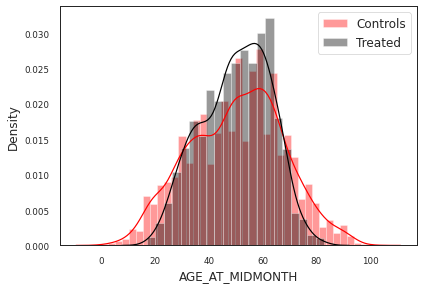

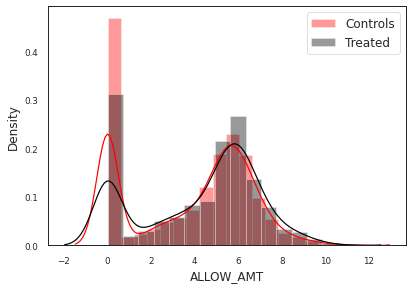

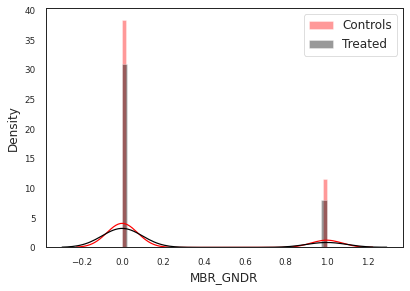

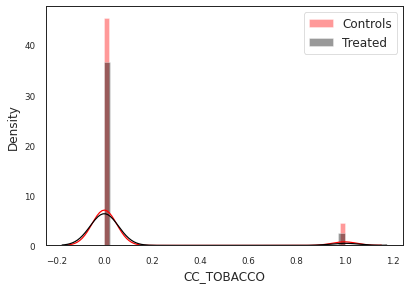

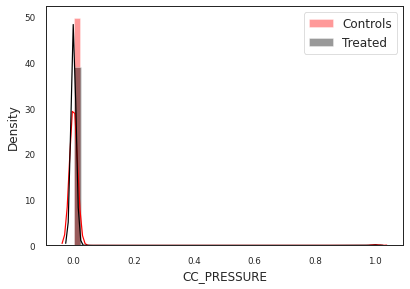

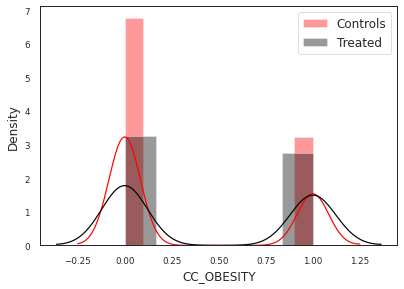

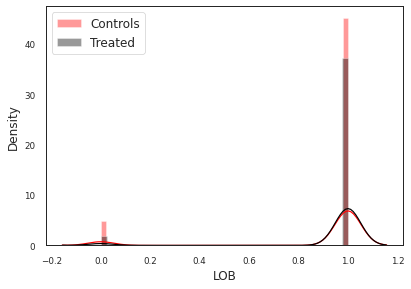

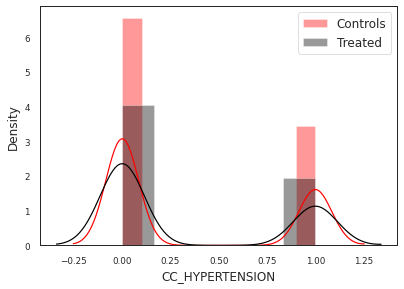

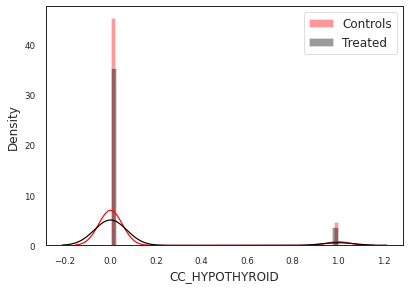

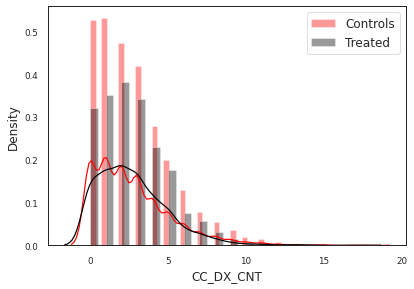

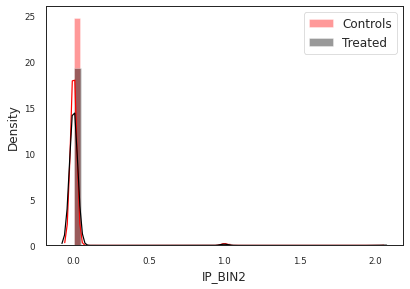

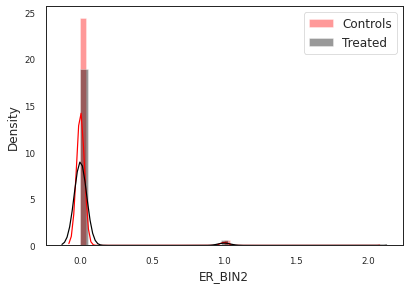

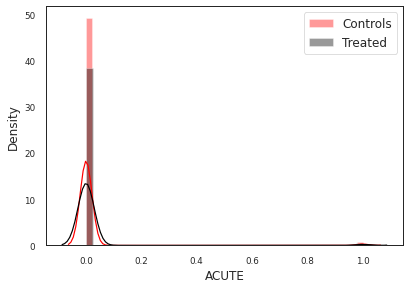

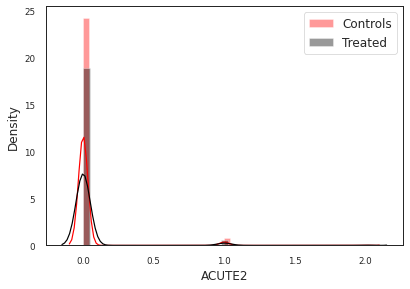

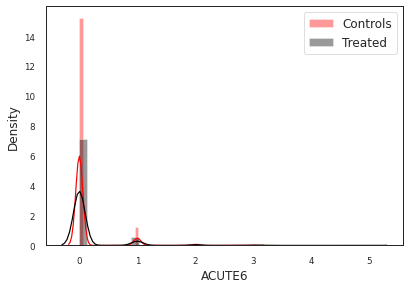

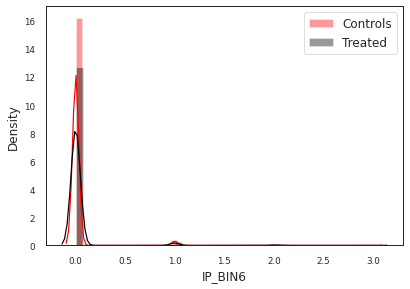

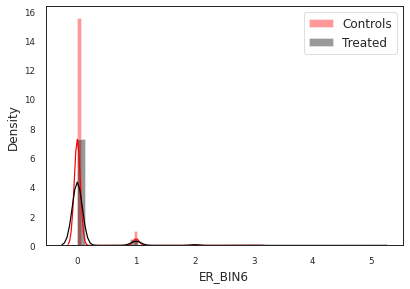

In [61]:
dist_plot_args = {'hist':True}
axes = plot_hist(treated_first_month.copy(), 
                 controls_first_month.copy(), mapping, ['ALLOW_AMT'] , 
                 data3 = None, 
                 save_path = 'res/figs/',
                dist_plot_args = dist_plot_args)

Save Three arrays
1. All Statistics
2. Only Means
3. Difference T-Statistic Pvalues

In [62]:
from diabetes_onset_plotter import save_arrays
p2 = Path('./res/tabs')
p2.mkdir(parents = True, exist_ok = True)
paths = ['./res/tabs/all_stats.csv', './res/tabs/only_means.csv', './res/tabs/only_stats.csv']
(all_paper, only_means, only_stats) = save_arrays(alli, paths, mapping)

In [63]:
all_paper


Treated  Matched Controls  T-Statistic  p-value  General Population  Random Match  Difference
AGE_AT_MIDMONTH   50.202            50.402       -0.430    0.667              44.643        47.578      -0.200
ALLOW_AMT        676.302           571.601        1.438    0.151            1086.869       680.205     104.701
MBR_GNDR           0.206             0.231       -2.215    0.027               0.441         0.429      -0.025
CC_TOBACCO         0.062             0.091       -3.720    0.000               0.076         0.096      -0.029
CC_PRESSURE        0.001             0.005       -2.084    0.037               0.008         0.007      -0.004
CC_OBESITY         0.457             0.322       10.310    0.000               0.113         0.228       0.135
LOB                0.952             0.904        6.172    0.000               0.759         0.785       0.048
CC_HYPERTENSION    0.324             0.344       -1.500    0.134               0.216         0.261      -0.020
CC_HYPOTHYROID     0.094             0.093        0.195    0.845               0.049         0.067       0.001
CC_DX_CNT          2.703             2.706       -0.046    0.963               1.882         2.388      -0.003
IP_BIN2            0.010             0.011       -0.333    0.739               0.021         0.015      -0.001
ER_BIN2            0.030             0.023        1.573    0.116               0.047         0.043       0.007
ACUTE              0.014             0.015       -0.059    0.953               0.063         0.027      -0.001
ACUTE2             0.038             0.032        1.031    0.303               0.063         0.054       0.006
ACUTE6             0.111             0.099        1.198    0.231               0.063         0.160       0.012
IP_BIN6            0.027             0.029       -0.292    0.770               0.021         0.045      -0.002
ER_BIN6            0.088             0.074        1.658    0.097               0.047         0.125       0.014

In [64]:
only_means

Treated  Matched Controls  General Population  Random Match
AGE_AT_MIDMONTH   50.202            50.402              44.643        47.578
ALLOW_AMT        676.302           571.601            1086.869       680.205
MBR_GNDR           0.206             0.231               0.441         0.429
CC_TOBACCO         0.062             0.091               0.076         0.096
CC_PRESSURE        0.001             0.005               0.008         0.007
CC_OBESITY         0.457             0.322               0.113         0.228
LOB                0.952             0.904               0.759         0.785
CC_HYPERTENSION    0.324             0.344               0.216         0.261
CC_HYPOTHYROID     0.094             0.093               0.049         0.067
CC_DX_CNT          2.703             2.706               1.882         2.388
IP_BIN2            0.010             0.011               0.021         0.015
ER_BIN2            0.030             0.023               0.047         0.043
ACUTE              0.014             0.015               0.063         0.027
ACUTE2             0.038             0.032               0.063         0.054
ACUTE6             0.111             0.099               0.063         0.160
IP_BIN6            0.027             0.029               0.021         0.045
ER_BIN6            0.088             0.074               0.047         0.125

In [65]:
only_stats

Difference  T-Statistic  p-value
AGE_AT_MIDMONTH      -0.200       -0.430    0.667
ALLOW_AMT           104.701        1.438    0.151
MBR_GNDR             -0.025       -2.215    0.027
CC_TOBACCO           -0.029       -3.720    0.000
CC_PRESSURE          -0.004       -2.084    0.037
CC_OBESITY            0.135       10.310    0.000
LOB                   0.048        6.172    0.000
CC_HYPERTENSION      -0.020       -1.500    0.134
CC_HYPOTHYROID        0.001        0.195    0.845
CC_DX_CNT            -0.003       -0.046    0.963
IP_BIN2              -0.001       -0.333    0.739
ER_BIN2               0.007        1.573    0.116
ACUTE                -0.001       -0.059    0.953
ACUTE2                0.006        1.031    0.303
ACUTE6                0.012        1.198    0.231
IP_BIN6              -0.002       -0.292    0.770
ER_BIN6               0.014        1.658    0.097

In [66]:
pmpm.MYR.max()

202104